In [81]:
import pandas as pd
import numpy as np
from scipy.misc import imread
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

In [45]:
def score(y_true, p_pred, eps=1e-15):
    
    for i in xrange(p_pred.shape[0]):
        
        if p_pred[i] < eps:
            p_pred[i] = eps
            
        elif p_pred[i] > 1 - eps:
            p_pred[i] = 1 - eps
        
    
    return -np.mean(y_true * np.log10(p_pred) + (1-y_true) * np.log(1-p_pred))

In [141]:
train = pd.read_csv('data/training.csv')
test = pd.read_csv('data/test.csv')

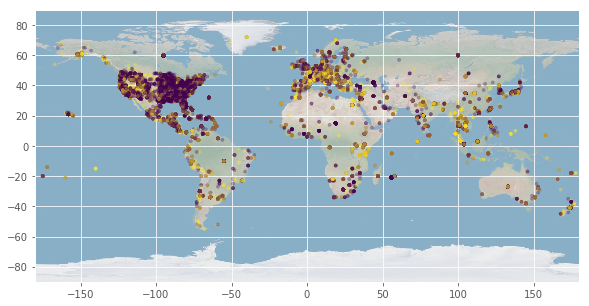

In [7]:
img = imread('data/map.jpg')
plt.scatter(train.longitude, train.latitude, c=train.good, s=10, alpha=0.3)
plt.imshow(img, extent=[-180,180,-90,90], alpha=0.4)
plt.show()

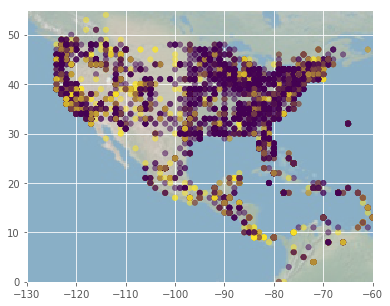

In [8]:
img = imread('data/map.jpg')
plt.scatter(train.longitude, train.latitude, c=train.good, s=30, alpha=0.5)
plt.imshow(img, extent=[-180,180,-90,90], alpha=0.4)
plt.xlim(-130, -60)
plt.ylim(0, 55)
plt.show()

## text

In [142]:
train['has_description'] = train.description.apply(lambda x: int(str(x) != 'nan'))
train['has_caption'] = train.caption.apply(lambda x: int(str(x) != 'nan'))
train['has_name'] = train.name.apply(lambda x: int(str(x) != 'nan'))

train.description = train.description.apply(lambda x: ' ' if str(x) == 'nan' else x )
train.caption = train.caption.apply(lambda x: ' ' if str(x) == 'nan' else x )
train.name = train.name.apply(lambda x: ' ' if str(x) == 'nan' else x )
train['text'] = train.name + ' ' + train.caption + ' ' + train.description
train['ratio'] = train.width / train.height


test['has_description'] = test.description.apply(lambda x: int(str(x) != 'nan'))
test['has_caption'] = test.caption.apply(lambda x: int(str(x) != 'nan'))
test['has_name'] = test.name.apply(lambda x: int(str(x) != 'nan'))

test.description = test.description.apply(lambda x: ' ' if str(x) == 'nan' else x )
test.caption = test.caption.apply(lambda x: ' ' if str(x) == 'nan' else x )
test.name = test.name.apply(lambda x: ' ' if str(x) == 'nan' else x )
test['text'] = test.name + ' ' + test.caption + ' ' + test.description
test['ratio'] = test.width / test.width


In [41]:
clf_pipe_nb = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), binary=False)),
                        ('tfidf', TfidfTransformer(use_idf=False)),
                        ('nb', MultinomialNB(alpha=0.1)),
                       ])

clf_pipe_log = Pipeline([('vect', CountVectorizer(ngram_range=(1, 5))),
                         ('tfidf', TfidfTransformer(use_idf=True)),
                         ('log', LogisticRegression(C=10))])

In [119]:
kf = KFold(n_splits=3)

for train_ind, test_ind in kf.split(train.good):
    
    X_train = train['text'].values[train_ind]
    y_train = train.iloc[train_ind].good.values
    
    X_test = train['text'].values[test_ind]
    y_test = train.iloc[test_ind].good.values
    
    clf_pipe_nb.fit(X_train, y_train)
    p_pred = clf_pipe_nb.predict_proba(X_test)[:,1]
    
    print 'score = ', score(y_test, p_pred)

score =  0.287314003662
score =  0.291536162188
score =  0.289768236522


In [144]:
skf = list(KFold(n_splits=10, shuffle=True).split(train.good))

def stacking(X_train, X_test, y_train, skf, clfs):
    
    meta_train = np.zeros((X_train.shape[0], len(clfs)))
    meta_test  = np.zeros((X_test.shape[0],  len(clfs)))
    
    for j, clf in enumerate(clfs):
        print('Clf', j+1)
        meta_test_j = np.zeros((X_test.shape[0], len(skf)))
        for i, (train, test) in enumerate(skf):
            print('Fold', i+1)
            X_tr = X_train[train]
            y_tr = y_train[train]
            X_ts = X_train[test]
            y_ts = y_train[test]
            clf.fit(X_tr, y_tr)
            y_submission = clf.predict_proba(X_ts)[:, 1]
            meta_train[test, j] = y_submission
            meta_test_j[:, i] = clf.predict_proba(X_test)[:, 1]
        meta_test[:, j] = meta_test_j.mean(1)
        
    return meta_train, meta_test

In [145]:
meta_train1, meta_test2 = stacking(train.text, test.text, train.good, skf, clfs=[clf_pipe_nb])

('Clf', 1)
('Fold', 1)
('Fold', 2)
('Fold', 3)
('Fold', 4)
('Fold', 5)
('Fold', 6)
('Fold', 7)
('Fold', 8)
('Fold', 9)
('Fold', 10)


In [146]:
train['M1'] = meta_train1

In [201]:
clf_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=5, n_jobs=-1, leaning_rate=0.1, verbose=True )
kf = KFold(n_splits=3)

for train_ind, test_ind in kf.split(train.good):
    
    X_train = train[['latitude', 'longitude', 'M1']].values[train_ind]
    y_train = train.iloc[train_ind].good.values
    
    X_test = train[['latitude', 'longitude', 'M1']].values[test_ind]
    y_test = train.iloc[test_ind].good.values
    
    clf_xgb.fit(X_train, y_train)
    p_pred = clf_xgb.predict_proba(X_test)[:,1]
    
    print 'score = ', score(y_test, p_pred)

score =  0.305592488327
score =  0.308448255084
score =  0.307889761034


In [202]:
score(train.good.values, train.M1.values)

0.29033810622355605

## Submit

In [44]:
pd.read_csv('data/example_entry.csv').head()

,id,good
0,40265,0
1,40266,0
2,40267,0
3,40268,0
4,40269,0


In [53]:
subm = pd.DataFrame(columns=['id', 'good'])
subm.id = test.id

In [63]:
X_subm = test[['name', 'description', 'caption']].values
X_subm = map(lambda x: x[0] + ' ' + x[1] + ' ' + x[2], X_subm)

In [73]:
p_subm = clf_pipe_nb.predict_proba(X_subm)[:,1]
subm.good = p_subm

In [77]:
subm.to_csv('data/subm/subm.csv', index=False)